In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts/ConceptBottleneck/')
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts')

In [3]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
from matplotlib.patches import Circle
import json
import argparse
import logging 

/usr0/home/naveenr/miniconda3/envs/concepts_spurious/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from ConceptBottleneck.CUB.dataset import load_data

In [5]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [6]:
logging.basicConfig(level=logging.INFO)
logging.info("Setting up dataset")

INFO:root:Setting up dataset


In [7]:
is_jupyter = 'ipykernel' in sys.modules
if is_jupyter:
    encoder_model='inceptionv3'
    seed = 42
    expand_dim_encoder = 0
    num_middle_encoder = 0
    mask_radius = 0.01
    dataset_name = "coco"
else:
    parser = argparse.ArgumentParser(description="Synthetic Dataset Experiments")

    parser.add_argument('--encoder_model', type=str, default='small3', help='Encoder model')
    parser.add_argument('--seed', type=int, default=42, help='Random seed')
    parser.add_argument('--expand_dim_encoder', type=int, default=0, help='For MLPs, size of the middle layer')
    parser.add_argument('--num_middle_encoder', type=int, default=0, help='For MLPs, number of middle layers')
    parser.add_argument('--mask_radius', type=float, default=.01, help='Radius of the mask for masking')
    parser.add_argument('--dataset_name', type=str, default="CUB", help='Dataset to analyze, such as CUB')

    args = parser.parse_args()
    encoder_model = args.encoder_model 
    seed = args.seed 
    expand_dim_encoder = args.expand_dim_encoder
    num_middle_encoder = args.num_middle_encoder
    mask_radius = args.mask_radius 
    dataset_name = args.dataset_name

parameters = {
    'seed': seed, 
    'encoder_model': encoder_model ,
    'dataset': dataset_name,
    'debugging': False,
    'epochs': 100,
    'lr': 5e-4, 
    "attr_loss_weight": 0.05, 
    'scheduler': 'none'
}


In [8]:
train_loader, val_loader, test_loader, train_pkl, val_pkl, test_pkl = get_data(1,encoder_model=encoder_model,dataset_name=dataset_name)

In [9]:
test_images, test_y, test_c = unroll_data(test_loader)

In [10]:
log_folder = get_log_folder(dataset_name,parameters).split("/")[-1]
results_folder = "../../results/{}/{}".format(dataset_name.lower(),log_folder)
if not os.path.exists(results_folder): 
    os.makedirs(results_folder)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
joint_model = get_synthetic_model(dataset_name,parameters)

In [21]:
joint_model = joint_model.to(device)

In [22]:
run_model_function = run_joint_model

## Plot the Dataset

In [23]:
logging.info("Plotting Dataset")

INFO:root:Plotting Dataset


In [24]:
dataset_directory = "../../../../datasets"

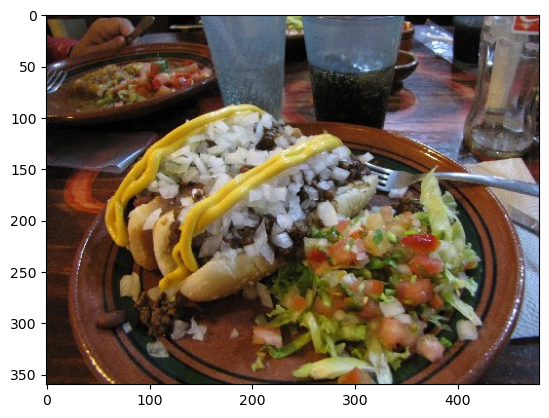

In [25]:
img_path = dataset_directory+'/'+train_pkl[0]['img_path']
image = Image.open(img_path)
plt.imshow(image)

## Accuracy

In [26]:
train_acc =  get_accuracy(joint_model,run_model_function,train_loader)
val_acc = get_accuracy(joint_model,run_model_function,val_loader)
test_acc = get_accuracy(joint_model,run_model_function,test_loader)

In [27]:
train_acc, val_acc, test_acc

(0.7717171717171717, 0.8528225806451613, 0.7788861180382377)

In [28]:
test_concept_f1 = get_f1_concept(joint_model,run_model_function,test_loader)
test_concept_f1

0.29092956373566076

In [29]:
torch.cuda.empty_cache()

## Using Part Annotations

In [30]:
logging.info("Using part annotations")

INFO:root:Using part annotations


In [31]:
train_locations = json.load(open(dataset_directory+"/coco/preprocessed/instances_train2014.json"))['annotations']
val_locations = json.load(open(dataset_directory+"/coco/preprocessed/instances_val2014.json"))['annotations']

In [32]:
concepts = pickle.load(open(dataset_directory+"/coco/preprocessed/concepts.pkl","rb"))

In [33]:
locations_by_image = {}
image_ids = set([i['id'] for i in train_pkl + val_pkl + test_pkl])
id_to_idx = {}

In [34]:
for i in train_locations + val_locations:
    if i ['image_id'] in image_ids and i['category_id'] in concepts:
        if i['image_id'] not in locations_by_image:
            locations_by_image[i['image_id']] = [[] for i in range(len(concepts))]
        locations_by_image[i['image_id']][concepts.index(i['category_id'])].append(i['bbox'])

#### Impact of Masking on Predictions

In [35]:
logging.info("Impact of Epsilon")

INFO:root:Impact of Epsilon


In [36]:
with torch.no_grad():
    initial_predictions = [] 

    for data_point in test_loader:
        x,y,c = data_point 
        _, initial_predictions_batch = run_joint_model(joint_model,x.to(device))
        initial_predictions_batch = torch.nn.Sigmoid()(initial_predictions_batch.detach().cpu().T)
        initial_predictions.append(initial_predictions_batch.numpy())
    initial_predictions = np.row_stack(initial_predictions)
    

In [37]:
torch.cuda.empty_cache()

In [38]:
results_by_part_mask = {}
test_data_num = 100
valid_pairs = [(i,j) for i in range(len(concepts)) for j in range(len(concepts)) if len(
    [k for k in range(len(test_pkl)) if test_c[k][i] == 1 and test_c[k][j] == 1]) > test_data_num]

In [47]:
for (main_part,mask_part) in valid_pairs:
    print("On main part {}".format(main_part))
    if concepts[main_part] not in results_by_part_mask:
        results_by_part_mask[concepts[main_part]] = {}

    test_images, test_y, test_c = unroll_data(test_loader)
    valid_data_points = [k for k in range(len(test_pkl)) if test_c[k][main_part] == 1 and test_c[k][mask_part] == 1]
    data_points = random.sample(valid_data_points,test_data_num)
    masked_dataset = [mask_bbox(test_images[idx],[get_new_x_y(locations_by_image[test_pkl[idx]['id']][mask_part][k],idx,test_pkl) for k in range(len(locations_by_image[test_pkl[idx]['id']][mask_part]))]) for idx in data_points]
    masked_dataset = torch.stack(masked_dataset)

    final_predictions = None 
    with torch.no_grad():
        _, final_predictions_batch = run_joint_model(joint_model,masked_dataset.to(device))
        final_predictions_batch = torch.nn.Sigmoid()(final_predictions_batch.detach().cpu().T)
        final_predictions = final_predictions_batch.numpy()     
    avg_diff = np.mean(np.abs(initial_predictions[data_points] - final_predictions)[:,main_part])
    std_diff = np.std(np.abs(initial_predictions[data_points] - final_predictions)[:,main_part])

    results_by_part_mask[concepts[main_part]][concepts[mask_part]] = (float(avg_diff),float(std_diff))

On main part 6


On main part 6
On main part 6
On main part 6
On main part 6
On main part 6
On main part 7
On main part 7
On main part 7
On main part 7
On main part 7
On main part 7
On main part 7
On main part 8
On main part 8
On main part 8
On main part 8
On main part 8
On main part 8
On main part 9
On main part 9
On main part 9
On main part 11
On main part 11
On main part 11
On main part 12
On main part 12
On main part 12
On main part 12
On main part 14
On main part 14
On main part 14
On main part 14


In [48]:
results_by_part_mask

{44: {86: (0.04325643554329872, 0.05391079932451248),
  44: (0.057430051267147064, 0.06750670820474625),
  47: (0.059560518711805344, 0.070724256336689),
  51: (0.06249244511127472, 0.06154421716928482),
  77: (0.040485598146915436, 0.051968663930892944),
  79: (0.07751338928937912, 0.06785793602466583)},
 47: {86: (0.04112877696752548, 0.04215247556567192),
  44: (0.05430000647902489, 0.04961547628045082),
  47: (0.06254950165748596, 0.0664711445569992),
  51: (0.06162877380847931, 0.07721704244613647),
  61: (0.1187814325094223, 0.11325516551733017),
  77: (0.043461523950099945, 0.05282072722911835),
  79: (0.08964470773935318, 0.0860312432050705)},
 51: {86: (0.0577717162668705, 0.07005827128887177),
  44: (0.058769870549440384, 0.06229827180504799),
  47: (0.05904609337449074, 0.06866738200187683),
  51: (0.07125260680913925, 0.0898795798420906),
  61: (0.11104774475097656, 0.11531165987253189),
  79: (0.08479023724794388, 0.06857302039861679)},
 61: {61: (0.10433585941791534, 0.11

In [49]:
results = {
    'part_mask': results_by_part_mask, 
    'parameters': {
        'seed': seed, 
        'concepts': concepts, 
        'images_per_mask': test_data_num, 
        'dataset': 'coco', 
    }, 
    'train_acc': train_acc,
    'val_acc': val_acc,
    'test_acc': test_acc,
}

In [45]:
json.dump(results_by_part_mask,open("../../results/coco/mask_{}.json".format(seed),"w"))